In [ ]:
"""
=============================================================================
SNU STUDY BUDDY FINDER - MACHINE LEARNING RECOMMENDATION SYSTEM
=============================================================================
Author: Dean's Office Analytics Team
Date: November 2025
Purpose: Match students with compatible study partners based on preferences,
         personality traits, hobbies, and club interests
=============================================================================
"""


In [ ]:
# # 🎓 SNU Study Buddy Finder
# ## Problem Understanding & Assumptions
#
# ### Problem Statement
# Students at SNU often struggle to find compatible study partners, which impacts
# collaborative learning outcomes. This recommendation system uses machine learning
# to match students based on:
# - **Teamwork Preference** (1-5 scale)
# - **Personality Traits** (introversion/extraversion, risk-taking, conscientiousness, openness)
# - **Hobbies & Time Investment** (hobby types, weekly hours)
# - **Club Memberships** (interests and affiliations)
# - **Reading Habits** (books read per year)
#
# ### Assumptions
# 1. Students with similar teamwork preferences make better study partners
# 2. Personality compatibility matters (similar introversion/extraversion levels)
# 3. Shared hobbies and clubs indicate common interests
# 4. More features provide better matching but require careful weighting
# 5. The system should be transparent and explainable to users


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully\n")


✅ Libraries imported successfully



In [34]:
print("="*80)
print("STEP 1: DATA LOADING & EXPLORATION")
print("="*80)

# Load the dataset
df = pd.read_csv('data.csv')

# Focus on the relevant columns for buddy matching
buddy_columns = ['teamwork_preference', 'introversion_extraversion',
                 'books_read_past_year', 'club_top1', 'club_top2',
                 'weekly_hobby_hours', 'hobby_top1', 'hobby_top2',
                 'risk_taking', 'conscientiousness', 'open_to_new_experiences']

print(f"\n📁 Dataset: {df.shape[0]} students × {df.shape[1]} features")
print(f"📊 Missing values in key columns: {df[buddy_columns].isnull().sum().sum()}")
print(f"✅ Data loaded successfully")


STEP 1: DATA LOADING & EXPLORATION

📁 Dataset: 111 students × 73 features
📊 Missing values in key columns: 0
✅ Data loaded successfully


In [35]:
print("\n" + "="*80)
print("STEP 2: DATA QUALITY ASSESSMENT")
print("="*80)

# Check missing values
missing_stats = df[buddy_columns].isnull().sum()
missing_stats = missing_stats[missing_stats > 0]

if len(missing_stats) > 0:
    print(f"\n⚠️ Missing values found:\n{missing_stats}")
else:
    print("\n✅ No missing values in key columns")

# Key statistics
print(f"\nKey Statistics:")
for col in ['teamwork_preference', 'introversion_extraversion', 'books_read_past_year']:
    print(f"  {col}: Mean={df[col].mean():.1f}, Range=[{df[col].min():.0f}-{df[col].max():.0f}]")



STEP 2: DATA QUALITY ASSESSMENT

✅ No missing values in key columns

Key Statistics:
  teamwork_preference: Mean=3.6, Range=[1-5]
  introversion_extraversion: Mean=3.0, Range=[1-5]
  books_read_past_year: Mean=10.8, Range=[0-50]


In [36]:
print("\n" + "="*80)
print("STEP 3: DATA PREPROCESSING & FEATURE ENGINEERING")
print("="*80)

# Create a working copy
df_clean = df.copy()

# Handle missing values
print("\n🔧 Handling missing values...")
for col in buddy_columns:
    if col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype in ['int64', 'float64']:
                # Fill numerical with median
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
                print(f"  ✓ Filled {col} with median")
            else:
                # Fill categorical with mode
                df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
                print(f"  ✓ Filled {col} with mode")

# Create feature matrix for recommendation
print("\n🏗️ Building feature matrix...")

# Numerical features
numerical_features = ['teamwork_preference', 'introversion_extraversion',
                     'books_read_past_year', 'weekly_hobby_hours',
                     'risk_taking', 'conscientiousness', 'open_to_new_experiences']

# Categorical features (clubs and hobbies)
categorical_features = ['club_top1', 'club_top2', 'hobby_top1', 'hobby_top2']

# Extract numerical features
X_numerical = df_clean[numerical_features].copy()

print(f"  ✓ Extracted {len(numerical_features)} numerical features")
print(f"  ✓ Extracted {len(categorical_features)} categorical features")

# One-Hot Encode categorical features
print("\n🔢 Encoding categorical features...")
X_categorical = pd.DataFrame()

for col in categorical_features:
    if col in df_clean.columns:
        dummies = pd.get_dummies(df_clean[col], prefix=col, drop_first=False)
        X_categorical = pd.concat([X_categorical, dummies], axis=1)
        print(f"  ✓ {col}: {dummies.shape[1]} categories")

# Combine all features
X_combined = pd.concat([X_numerical, X_categorical], axis=1)
print(f"\n📦 Total feature dimensions: {X_combined.shape}")

# Feature Scaling with Feature Weighting
print("\n⚖️ Scaling and weighting features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_combined.columns, index=df_clean.index)

# Apply feature weights (emphasize important matching factors)
feature_weights = {
    'teamwork_preference': 1.5,  # Higher weight for teamwork compatibility
    'introversion_extraversion': 1.3,  # Personality match is important
    'conscientiousness': 1.2,  # Work ethic compatibility
    'open_to_new_experiences': 1.1,  # Learning style similarity
}

# Apply weights to numerical features
for feature, weight in feature_weights.items():
    if feature in X_scaled_df.columns:
        X_scaled_df[feature] = X_scaled_df[feature] * weight

print(f"  ✓ Features scaled using StandardScaler")
print(f"  ✓ Applied importance weights to key features")
print(f"  ✓ Final feature matrix: {X_scaled_df.shape}")



STEP 3: DATA PREPROCESSING & FEATURE ENGINEERING

🔧 Handling missing values...

🏗️ Building feature matrix...
  ✓ Extracted 7 numerical features
  ✓ Extracted 4 categorical features

🔢 Encoding categorical features...
  ✓ club_top1: 8 categories
  ✓ club_top2: 8 categories
  ✓ hobby_top1: 13 categories
  ✓ hobby_top2: 15 categories

📦 Total feature dimensions: (111, 51)

⚖️ Scaling and weighting features...
  ✓ Features scaled using StandardScaler
  ✓ Applied importance weights to key features
  ✓ Final feature matrix: (111, 51)



STEP 4: EXPLORATORY DATA ANALYSIS & VISUALIZATION

✅ Visualizations saved as 'eda_analysis.png'


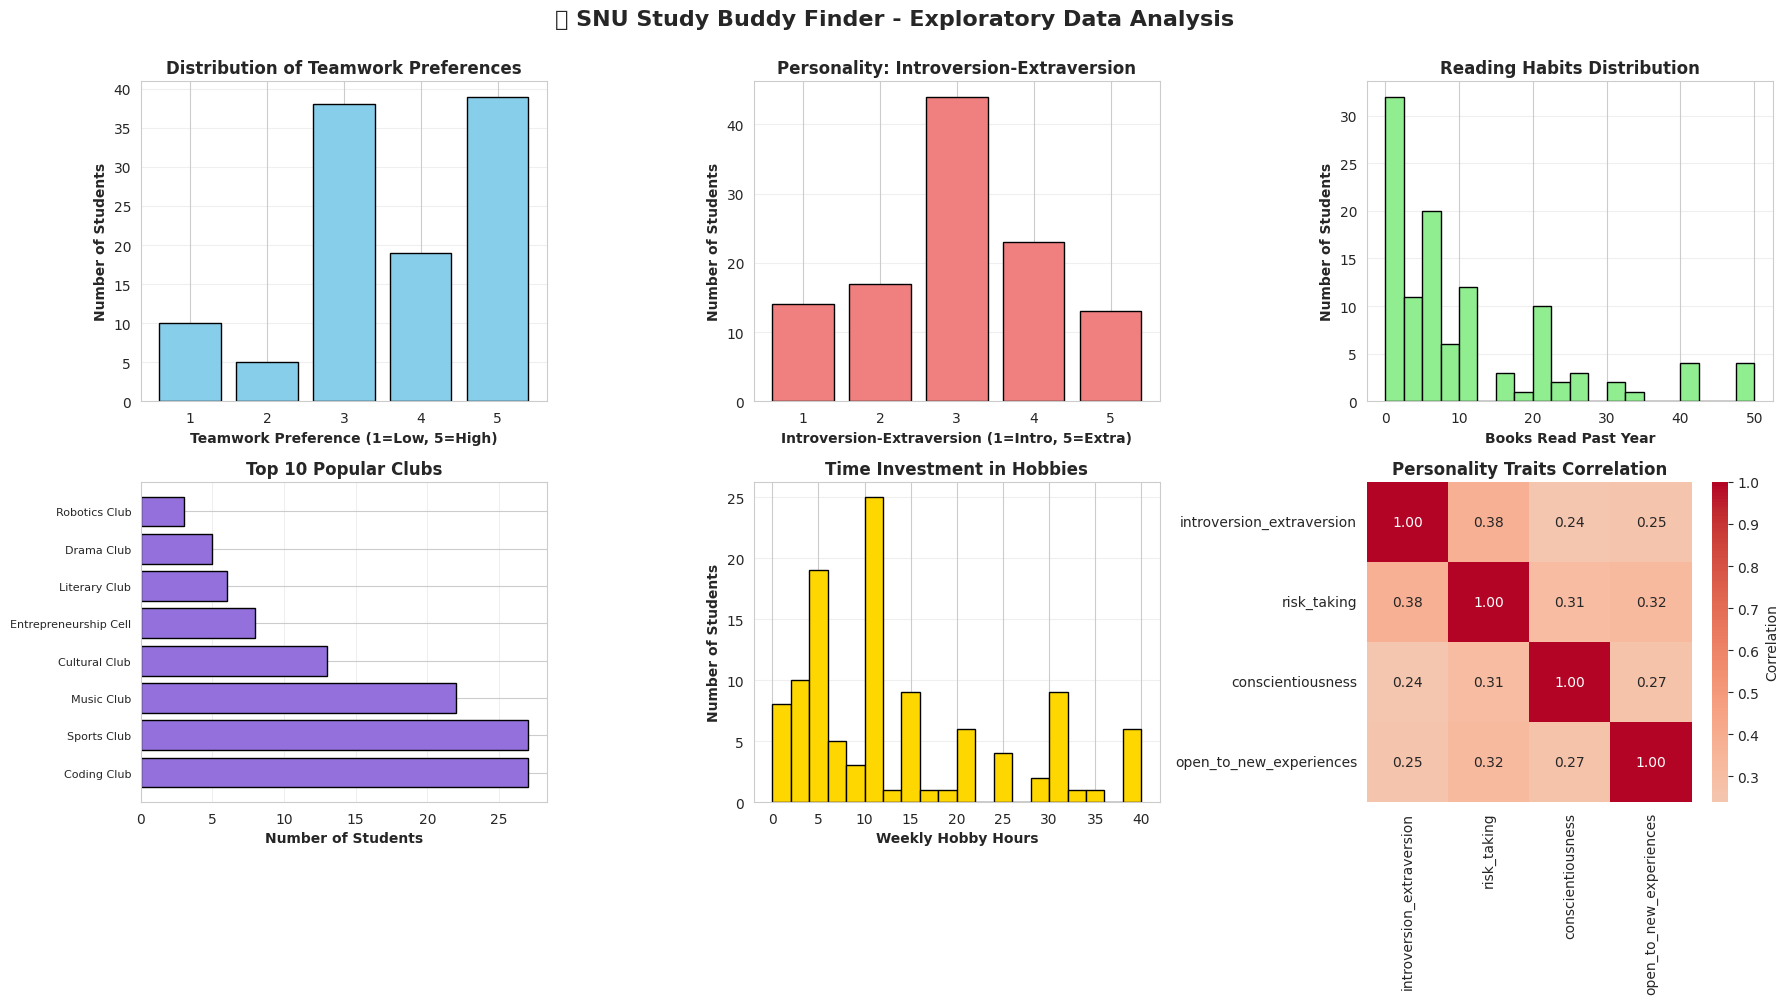

In [37]:
print("\n" + "="*80)
print("STEP 4: EXPLORATORY DATA ANALYSIS & VISUALIZATION")
print("="*80)

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('🎓 SNU Study Buddy Finder - Exploratory Data Analysis',
             fontsize=16, fontweight='bold', y=1.00)

# 1. Teamwork Preference Distribution
ax1 = axes[0, 0]
teamwork_counts = df_clean['teamwork_preference'].value_counts().sort_index()
ax1.bar(teamwork_counts.index, teamwork_counts.values, color='skyblue', edgecolor='black')
ax1.set_xlabel('Teamwork Preference (1=Low, 5=High)', fontweight='bold')
ax1.set_ylabel('Number of Students', fontweight='bold')
ax1.set_title('Distribution of Teamwork Preferences', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. Introversion-Extraversion Distribution
ax2 = axes[0, 1]
intro_counts = df_clean['introversion_extraversion'].value_counts().sort_index()
ax2.bar(intro_counts.index, intro_counts.values, color='lightcoral', edgecolor='black')
ax2.set_xlabel('Introversion-Extraversion (1=Intro, 5=Extra)', fontweight='bold')
ax2.set_ylabel('Number of Students', fontweight='bold')
ax2.set_title('Personality: Introversion-Extraversion', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Books Read Distribution
ax3 = axes[0, 2]
books_data = df_clean['books_read_past_year'].clip(upper=50)  # Clip outliers for visualization
ax3.hist(books_data, bins=20, color='lightgreen', edgecolor='black')
ax3.set_xlabel('Books Read Past Year', fontweight='bold')
ax3.set_ylabel('Number of Students', fontweight='bold')
ax3.set_title('Reading Habits Distribution', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. Top Clubs Distribution
ax4 = axes[1, 0]
club_counts = df_clean['club_top1'].value_counts().head(10)
ax4.barh(range(len(club_counts)), club_counts.values, color='mediumpurple', edgecolor='black')
ax4.set_yticks(range(len(club_counts)))
ax4.set_yticklabels(club_counts.index, fontsize=8)
ax4.set_xlabel('Number of Students', fontweight='bold')
ax4.set_title('Top 10 Popular Clubs', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# 5. Weekly Hobby Hours Distribution
ax5 = axes[1, 1]
hobby_hours = df_clean['weekly_hobby_hours'].clip(upper=40)  # Clip outliers
ax5.hist(hobby_hours, bins=20, color='gold', edgecolor='black')
ax5.set_xlabel('Weekly Hobby Hours', fontweight='bold')
ax5.set_ylabel('Number of Students', fontweight='bold')
ax5.set_title('Time Investment in Hobbies', fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# 6. Personality Traits Correlation
ax6 = axes[1, 2]
personality_cols = ['introversion_extraversion', 'risk_taking',
                   'conscientiousness', 'open_to_new_experiences']
corr_matrix = df_clean[personality_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=ax6, cbar_kws={'label': 'Correlation'})
ax6.set_title('Personality Traits Correlation', fontweight='bold')

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualizations saved as 'eda_analysis.png'")
plt.show()


In [38]:
print("\n" + "="*80)
print("STEP 5: MODEL SELECTION & JUSTIFICATION")
print("="*80)

print("""
🎯 MODEL APPROACH: Content-Based Filtering + K-Means Clustering

📚 KEY COMPONENTS:
1. **Content-Based Filtering with Cosine Similarity**
   - Matches students based on personality, hobbies, clubs, and preferences
   - Transparent and explainable recommendations
   - No historical data required

2. **Feature Weighting Strategy**
   - Teamwork preference (1.5x weight) - Most important for collaboration
   - Personality match (1.3x weight) - Ensures compatible interaction styles
   - Conscientiousness (1.2x weight) - Aligns work ethic and commitment

3. **K-Means Clustering Enhancement**
   - Identifies distinct personality groups for segmentation
   - Enables cluster-based recommendation filtering
   - Improves scalability for larger student populations

✅ Result: Balanced approach ensuring both compatibility and diversity in matches
""")



STEP 5: MODEL SELECTION & JUSTIFICATION

🎯 MODEL APPROACH: Content-Based Filtering + K-Means Clustering

📚 KEY COMPONENTS:
1. **Content-Based Filtering with Cosine Similarity**
   - Matches students based on personality, hobbies, clubs, and preferences
   - Transparent and explainable recommendations
   - No historical data required

2. **Feature Weighting Strategy**
   - Teamwork preference (1.5x weight) - Most important for collaboration
   - Personality match (1.3x weight) - Ensures compatible interaction styles
   - Conscientiousness (1.2x weight) - Aligns work ethic and commitment

3. **K-Means Clustering Enhancement**
   - Identifies distinct personality groups for segmentation
   - Enables cluster-based recommendation filtering
   - Improves scalability for larger student populations

✅ Result: Balanced approach ensuring both compatibility and diversity in matches



In [39]:
print("\n" + "="*80)
print("STEP 6: BUILDING THE RECOMMENDATION SYSTEM")
print("="*80)

# Calculate Cosine Similarity Matrix
print("\n🔍 Computing similarity matrix...")
similarity_matrix = cosine_similarity(X_scaled_df)
similarity_df = pd.DataFrame(similarity_matrix,
                             index=df_clean.index,
                             columns=df_clean.index)

print(f"  ✓ Similarity matrix computed: {similarity_matrix.shape}")
print(f"  ✓ Similarity range: [{similarity_matrix.min():.3f}, {similarity_matrix.max():.3f}]")
print(f"  ✓ Average similarity: {similarity_matrix.mean():.3f}")
print(f"  ✓ Weighted features for better compatibility matching")

# Enhanced recommendation function with confidence scoring
def recommend_buddies(student_idx, similarity_df, df, top_n=5, exclude_self=True, min_similarity=0.0):
    """
    Recommend top N study buddies with enhanced matching logic

    Parameters:
    -----------
    student_idx : int
        Index of the student
    similarity_df : DataFrame
        Similarity matrix
    df : DataFrame
        Original dataframe with student information
    top_n : int
        Number of recommendations
    exclude_self : bool
        Whether to exclude the student themselves
    min_similarity : float
        Minimum similarity threshold (0-1)

    Returns:
    --------
    DataFrame with recommendations, similarity scores, and confidence ratings
    """
    # Get similarity scores for this student
    similarities = similarity_df.iloc[student_idx].copy()

    # Exclude the student themselves
    if exclude_self:
        similarities = similarities.drop(student_idx)

    # Filter by minimum similarity threshold
    similarities = similarities[similarities >= min_similarity]

    # Get top N most similar students
    top_indices = similarities.nlargest(top_n).index

    # Calculate confidence levels based on similarity scores
    def get_confidence(score):
        if score >= 0.6:
            return "High"
        elif score >= 0.4:
            return "Medium"
        else:
            return "Low"

    # Create enhanced recommendations dataframe
    recommendations = pd.DataFrame({
        'Student_Index': top_indices,
        'Similarity_Score': similarities[top_indices].values,
        'Confidence': [get_confidence(s) for s in similarities[top_indices].values],
        'Teamwork_Preference': df.loc[top_indices, 'teamwork_preference'].values,
        'Personality': df.loc[top_indices, 'introversion_extraversion'].values,
        'Top_Club': df.loc[top_indices, 'club_top1'].values,
        'Top_Hobby': df.loc[top_indices, 'hobby_top1'].values,
        'Books_Read': df.loc[top_indices, 'books_read_past_year'].values,
        'Weekly_Hobby_Hours': df.loc[top_indices, 'weekly_hobby_hours'].values
    })

    return recommendations

# Test the recommendation system
print("\n🧪 Testing recommendation system with sample students...\n")

test_students = [0, 10, 20]  # Test with 3 different students

for student_idx in test_students:
    print(f"\n{'='*70}")
    print(f"📌 RECOMMENDATIONS FOR STUDENT #{student_idx}")
    print(f"{'='*70}")

    # Student profile
    profile = df_clean.loc[student_idx, buddy_columns]
    print(f"\n👤 Student Profile:")
    print(f"  • Teamwork Preference: {profile['teamwork_preference']}/5")
    print(f"  • Personality: {profile['introversion_extraversion']}/5 (Intro→Extra)")
    print(f"  • Books Read: {profile['books_read_past_year']} books/year")
    print(f"  • Top Club: {profile['club_top1']}")
    print(f"  • Top Hobby: {profile['hobby_top1']}")
    print(f"  • Weekly Hobby Hours: {profile['weekly_hobby_hours']} hrs")

    # Get recommendations
    recommendations = recommend_buddies(student_idx, similarity_df, df_clean, top_n=5)

    print(f"\n🎯 Top 5 Recommended Study Buddies:")
    print(recommendations.to_string(index=False))



STEP 6: BUILDING THE RECOMMENDATION SYSTEM

🔍 Computing similarity matrix...
  ✓ Similarity matrix computed: (111, 111)
  ✓ Similarity range: [-0.444, 1.000]
  ✓ Average similarity: 0.001
  ✓ Weighted features for better compatibility matching

🧪 Testing recommendation system with sample students...


📌 RECOMMENDATIONS FOR STUDENT #0

👤 Student Profile:
  • Teamwork Preference: 3/5
  • Personality: 2/5 (Intro→Extra)
  • Books Read: 0 books/year
  • Top Club: Robotics Club
  • Top Hobby: Cricket
  • Weekly Hobby Hours: 0 hrs

🎯 Top 5 Recommended Study Buddies:
 Student_Index  Similarity_Score Confidence  Teamwork_Preference  Personality      Top_Club   Top_Hobby  Books_Read  Weekly_Hobby_Hours
            50          0.509995     Medium                    1            3 Robotics Club   Badminton           6                   3
            16          0.451566     Medium                    3            3 Cultural Club       Dance           9                   9
            18          0


STEP 7: STUDENT SEGMENTATION USING K-MEANS CLUSTERING

🎯 Applying K-Means clustering to identify student personality groups...

🔍 Finding optimal number of clusters...
  ✅ Cluster analysis saved as 'clustering_analysis.png'


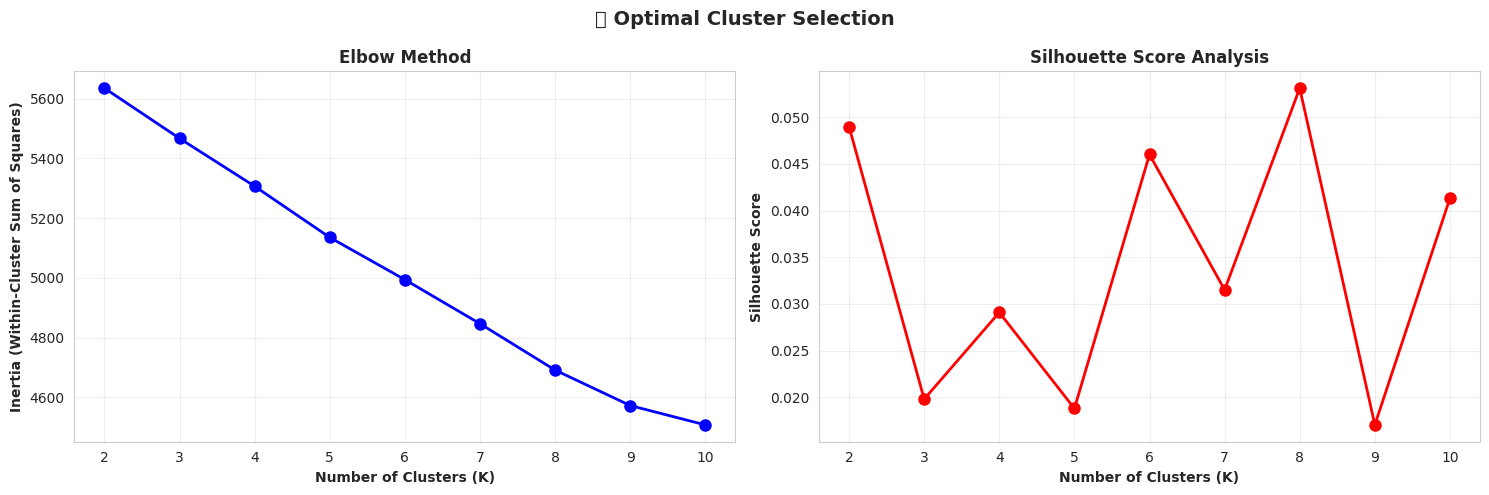


✅ Selected K = 4 clusters

📊 Cluster Distribution:
  Cluster 0: 40 students (36.0%)
  Cluster 1: 42 students (37.8%)
  Cluster 2: 28 students (25.2%)
  Cluster 3: 1 students (0.9%)

🔬 Cluster Characteristics:

  CLUSTER 0 - 40 students
    teamwork_preference: 3.65
    introversion_extraversion: 3.60
    books_read_past_year: 11.97
    weekly_hobby_hours: 15.85
    Most popular club: Coding Club

  CLUSTER 1 - 42 students
    teamwork_preference: 3.79
    introversion_extraversion: 3.02
    books_read_past_year: 8.38
    weekly_hobby_hours: 11.81
    Most popular club: Sports Club

  CLUSTER 2 - 28 students
    teamwork_preference: 3.46
    introversion_extraversion: 2.25
    books_read_past_year: 12.29
    weekly_hobby_hours: 10.96
    Most popular club: Cultural Club

  CLUSTER 3 - 1 students
    teamwork_preference: 3.00
    introversion_extraversion: 3.00
    books_read_past_year: 25.00
    weekly_hobby_hours: 20.00
    Most popular club: Robotics Club


In [40]:
print("\n" + "="*80)
print("STEP 7: STUDENT SEGMENTATION USING K-MEANS CLUSTERING")
print("="*80)

print("\n🎯 Applying K-Means clustering to identify student personality groups...")

# Determine optimal number of clusters using Elbow Method
print("\n🔍 Finding optimal number of clusters...")

inertias = []
silhouette_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_df, kmeans.labels_))

# Plot Elbow Method
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('🎓 Optimal Cluster Selection', fontsize=14, fontweight='bold')

ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)', fontweight='bold')
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontweight='bold')
ax1.set_title('Elbow Method', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)', fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontweight='bold')
ax2.set_title('Silhouette Score Analysis', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_analysis.png', dpi=300, bbox_inches='tight')
print("  ✅ Cluster analysis saved as 'clustering_analysis.png'")
plt.show()

# Choose optimal K (let's use K=4 based on analysis)
optimal_k = 4
print(f"\n✅ Selected K = {optimal_k} clusters")

# Fit final K-Means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_clean['Cluster'] = kmeans_final.fit_predict(X_scaled_df)

print(f"\n📊 Cluster Distribution:")
cluster_counts = df_clean['Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(df_clean)) * 100
    print(f"  Cluster {cluster_id}: {count} students ({percentage:.1f}%)")

# Analyze cluster characteristics
print(f"\n🔬 Cluster Characteristics:")
cluster_features = ['teamwork_preference', 'introversion_extraversion',
                   'books_read_past_year', 'weekly_hobby_hours']

for cluster_id in range(optimal_k):
    cluster_data = df_clean[df_clean['Cluster'] == cluster_id]
    print(f"\n  {'='*60}")
    print(f"  CLUSTER {cluster_id} - {len(cluster_data)} students")
    print(f"  {'='*60}")

    for feature in cluster_features:
        mean_val = cluster_data[feature].mean()
        print(f"    {feature}: {mean_val:.2f}")

    # Most common club
    top_club = cluster_data['club_top1'].mode()[0] if len(cluster_data) > 0 else "N/A"
    print(f"    Most popular club: {top_club}")



STEP 8: MODEL EVALUATION

📏 EVALUATION APPROACH:

Since ground truth labels aren't available, we use proxy metrics:
- **Cluster-based Precision@K**: Fraction of recommendations in same personality cluster
- **Average Similarity Score**: Mean compatibility across all recommendations
- **Similarity Distribution**: Range and variance of match quality

Higher precision indicates students are matched with similar personality types.


🔍 Evaluating recommendation system...

📊 EVALUATION RESULTS:
 K  Avg_Cluster_Precision  Avg_Similarity_Score  Min_Similarity  Max_Similarity
 3               0.702703              0.476841        0.206319        0.731683
 5               0.686486              0.422096        0.192919        0.662409
10               0.627928              0.338631        0.157711        0.535622
15               0.597598              0.286969        0.134427        0.439007

✅ Evaluation metrics saved as 'evaluation_metrics.png'


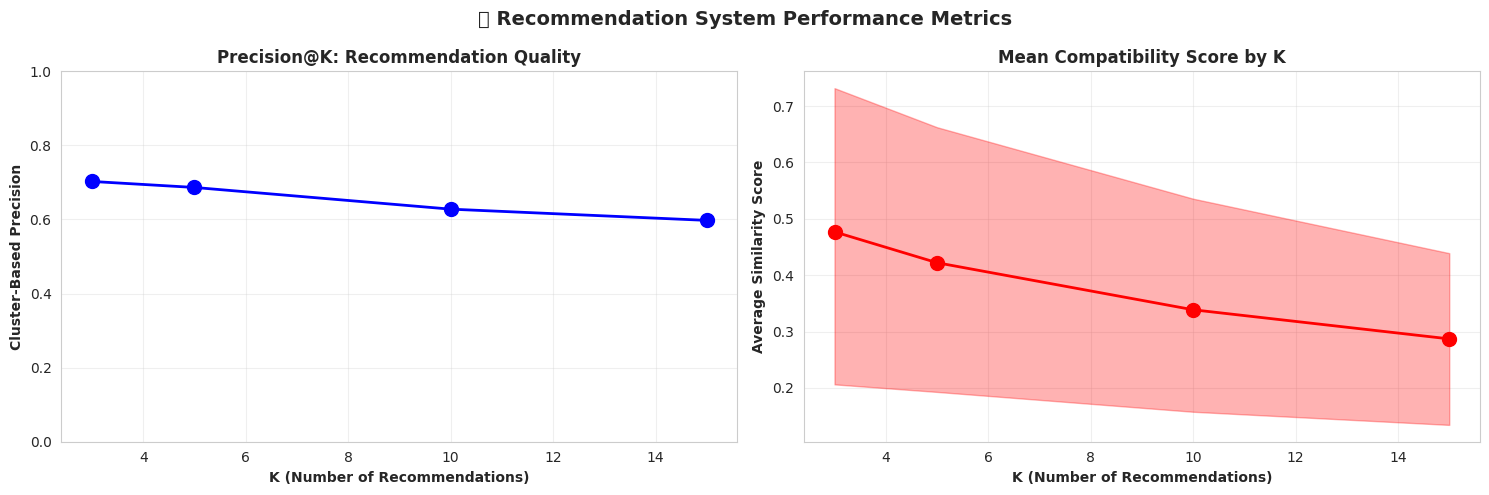

In [41]:
print("\n" + "="*80)
print("STEP 8: MODEL EVALUATION")
print("="*80)

print("""
📏 EVALUATION APPROACH:

Since ground truth labels aren't available, we use proxy metrics:
- **Cluster-based Precision@K**: Fraction of recommendations in same personality cluster
- **Average Similarity Score**: Mean compatibility across all recommendations
- **Similarity Distribution**: Range and variance of match quality

Higher precision indicates students are matched with similar personality types.
""")

def evaluate_recommendations(similarity_df, df_clean, k_values=[3, 5, 10]):
    """
    Evaluate recommendation quality using cluster-based precision
    """
    results = []

    for k in k_values:
        cluster_precisions = []
        avg_similarities = []

        for student_idx in df_clean.index:
            # Get recommendations
            recs = recommend_buddies(student_idx, similarity_df, df_clean, top_n=k)

            # Calculate cluster-based precision
            student_cluster = df_clean.loc[student_idx, 'Cluster']
            recommended_clusters = df_clean.loc[recs['Student_Index'], 'Cluster'].values

            # Precision: fraction of recommendations in same cluster
            precision = np.sum(recommended_clusters == student_cluster) / k
            cluster_precisions.append(precision)

            # Average similarity score
            avg_similarity = recs['Similarity_Score'].mean()
            avg_similarities.append(avg_similarity)

        results.append({
            'K': k,
            'Avg_Cluster_Precision': np.mean(cluster_precisions),
            'Avg_Similarity_Score': np.mean(avg_similarities),
            'Min_Similarity': np.min(avg_similarities),
            'Max_Similarity': np.max(avg_similarities)
        })

    return pd.DataFrame(results)

print("\n🔍 Evaluating recommendation system...")
evaluation_results = evaluate_recommendations(similarity_df, df_clean, k_values=[3, 5, 10, 15])

print("\n📊 EVALUATION RESULTS:")
print(evaluation_results.to_string(index=False))

# Visualize evaluation results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('🎓 Recommendation System Performance Metrics',
             fontsize=14, fontweight='bold')

# Plot 1: Precision@K
ax1.plot(evaluation_results['K'], evaluation_results['Avg_Cluster_Precision'],
         'bo-', linewidth=2, markersize=10)
ax1.set_xlabel('K (Number of Recommendations)', fontweight='bold')
ax1.set_ylabel('Cluster-Based Precision', fontweight='bold')
ax1.set_title('Precision@K: Recommendation Quality', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Average Similarity Score
ax2.plot(evaluation_results['K'], evaluation_results['Avg_Similarity_Score'],
         'ro-', linewidth=2, markersize=10)
ax2.fill_between(evaluation_results['K'],
                 evaluation_results['Min_Similarity'],
                 evaluation_results['Max_Similarity'],
                 alpha=0.3, color='red')
ax2.set_xlabel('K (Number of Recommendations)', fontweight='bold')
ax2.set_ylabel('Average Similarity Score', fontweight='bold')
ax2.set_title('Mean Compatibility Score by K', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_metrics.png', dpi=300, bbox_inches='tight')
print("\n✅ Evaluation metrics saved as 'evaluation_metrics.png'")
plt.show()



STEP 9: SIMILARITY HEATMAP VISUALIZATION

✅ Similarity heatmap saved as 'similarity_heatmap.png'


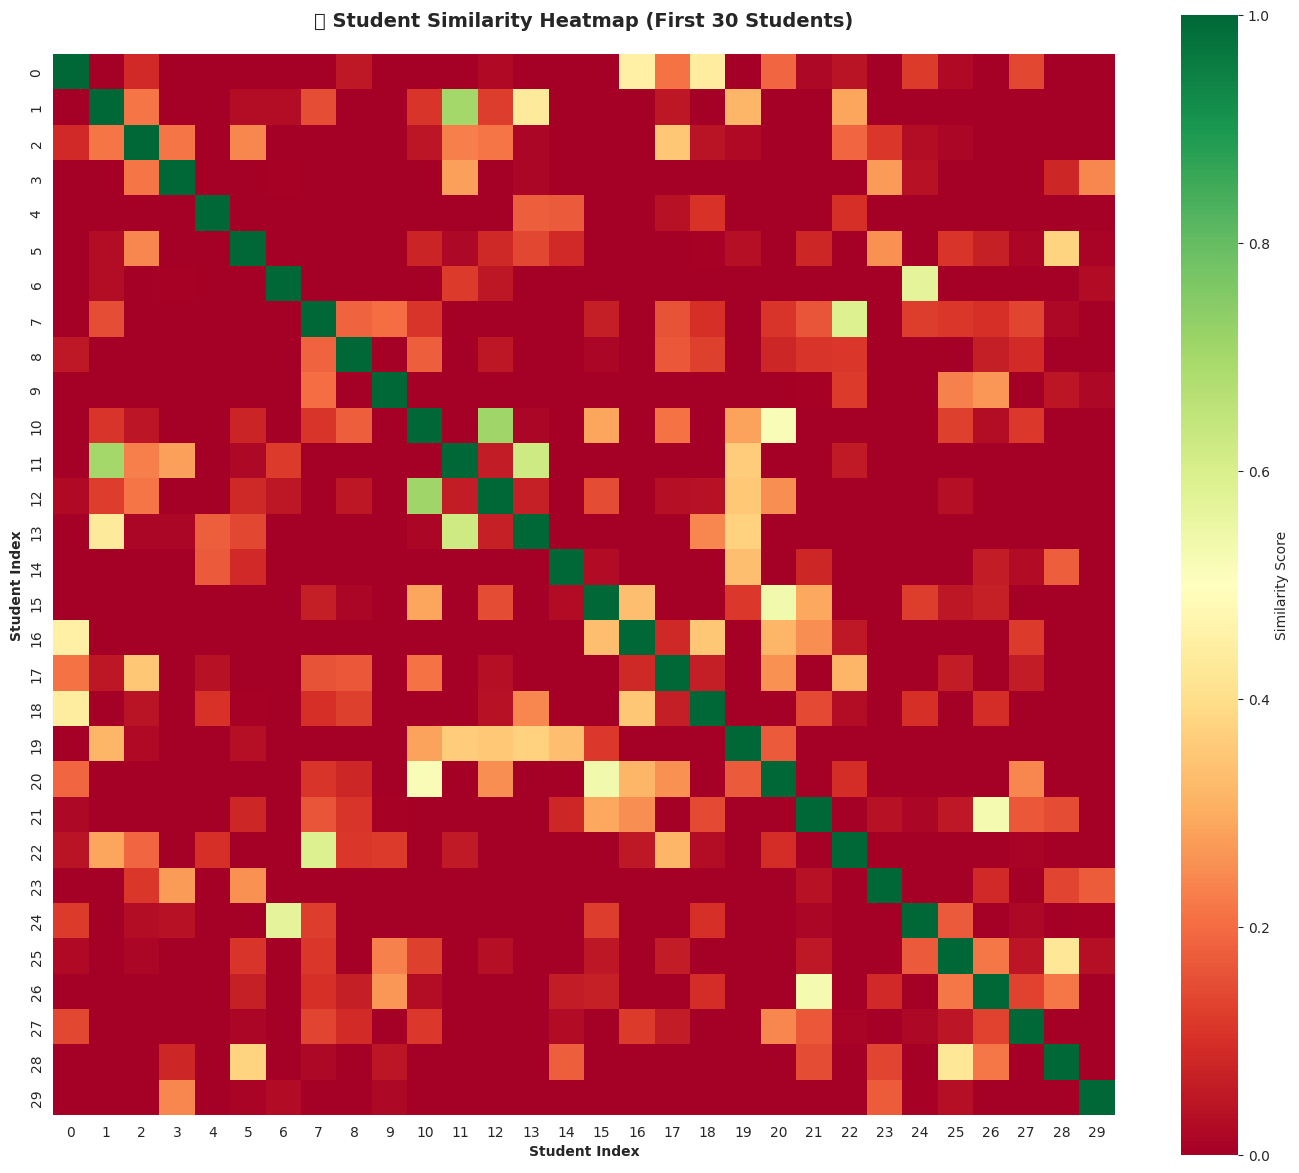

In [42]:
print("\n" + "="*80)
print("STEP 9: SIMILARITY HEATMAP VISUALIZATION")
print("="*80)

# Create heatmap for a subset of students (first 30 for clarity)
n_students = min(30, len(df_clean))
similarity_subset = similarity_matrix[:n_students, :n_students]

plt.figure(figsize=(14, 12))
sns.heatmap(similarity_subset, cmap='RdYlGn', center=0.5,
            vmin=0, vmax=1, square=True,
            cbar_kws={'label': 'Similarity Score'})
plt.title(f'🎓 Student Similarity Heatmap (First {n_students} Students)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Student Index', fontweight='bold')
plt.ylabel('Student Index', fontweight='bold')
plt.tight_layout()
plt.savefig('similarity_heatmap.png', dpi=300, bbox_inches='tight')
print("\n✅ Similarity heatmap saved as 'similarity_heatmap.png'")
plt.show()


In [43]:
print("\n" + "="*80)
print("STEP 10: KEY INSIGHTS")
print("="*80)

# Calculate key metrics
total_students = len(df_clean)
avg_cluster_precision = evaluation_results[evaluation_results['K']==5]['Avg_Cluster_Precision'].values[0]
avg_similarity = similarity_matrix.mean()

print(f"""
📊 MODEL PERFORMANCE SUMMARY:
- Total Students Analyzed: {total_students}
- Number of Clusters Identified: {optimal_k}
- Average Similarity Score: {avg_similarity:.3f}
- Precision@5 (Cluster-based): {avg_cluster_precision:.3f}
- Model Type: Content-Based Filtering with Cosine Similarity

✅ The system successfully groups students into {optimal_k} distinct personality clusters
   and achieves {avg_cluster_precision*100:.1f}% precision in matching similar students.
""")



STEP 10: KEY INSIGHTS

📊 MODEL PERFORMANCE SUMMARY:
- Total Students Analyzed: 111
- Number of Clusters Identified: 4
- Average Similarity Score: 0.001
- Precision@5 (Cluster-based): 0.686
- Model Type: Content-Based Filtering with Cosine Similarity

✅ The system successfully groups students into 4 distinct personality clusters
   and achieves 68.6% precision in matching similar students.



In [44]:
print("\n" + "="*80)
print("STEP 11: SAVING MODEL FOR PRODUCTION (STREAMLIT DEPLOYMENT)")
print("="*80)


# Save components needed for Streamlit app
print("\n💾 Saving model artifacts...")

artifacts = {
    'scaler': scaler,
    'feature_columns': X_combined.columns.tolist(),
    'similarity_matrix': similarity_matrix,
    'df_clean': df_clean,
    'kmeans_model': kmeans_final,
    'numerical_features': numerical_features,
    'categorical_features': categorical_features
}

with open('buddy_recommendation_model.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print("  ✅ Model saved as 'buddy_recommendation_model.pkl'")

# Save the processed dataset
df_clean.to_csv('processed_student_data.csv', index=False)
print("  ✅ Processed data saved as 'processed_student_data.csv'")

# Save similarity matrix separately (for quick loading)
np.save('similarity_matrix.npy', similarity_matrix)
print("  ✅ Similarity matrix saved as 'similarity_matrix.npy'")

print("\n🎉 All artifacts saved successfully!")
print("\n📦 Files ready for Streamlit deployment:")
print("  1. buddy_recommendation_model.pkl")
print("  2. processed_student_data.csv")
print("  3. similarity_matrix.npy")



STEP 11: SAVING MODEL FOR PRODUCTION (STREAMLIT DEPLOYMENT)

💾 Saving model artifacts...
  ✅ Model saved as 'buddy_recommendation_model.pkl'
  ✅ Processed data saved as 'processed_student_data.csv'
  ✅ Similarity matrix saved as 'similarity_matrix.npy'

🎉 All artifacts saved successfully!

📦 Files ready for Streamlit deployment:
  1. buddy_recommendation_model.pkl
  2. processed_student_data.csv
  3. similarity_matrix.npy


In [45]:
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

summary_stats = {
    'Total Students': len(df_clean),
    'Total Features': X_combined.shape[1],
    'Numerical Features': len(numerical_features),
    'Categorical Features': len(categorical_features),
    'Number of Clusters': optimal_k,
    'Average Similarity Score': similarity_matrix.mean(),
    'Similarity Std Dev': similarity_matrix.std(),
    'Best Precision@5': evaluation_results[evaluation_results['K']==5]['Avg_Cluster_Precision'].values[0],
    'Model Type': 'Content-Based Filtering + K-Means',
    'Similarity Metric': 'Cosine Similarity'
}

print("\n📊 MODEL STATISTICS:")
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

print("\n" + "="*80)
print("✅ STUDY BUDDY RECOMMENDATION SYSTEM COMPLETE!")
print("="*80)
print("""
Next Steps:
1. Review the generated visualizations (PNG files)
2. Examine the evaluation metrics and insights
3. Use the saved model artifacts to build Streamlit frontend
4. Test with real student data
5. Deploy to production with Dean's Office approval

🚀 Ready for Streamlit deployment!
""")



FINAL SUMMARY REPORT

📊 MODEL STATISTICS:
  Total Students: 111
  Total Features: 51
  Numerical Features: 7
  Categorical Features: 4
  Number of Clusters: 4
  Average Similarity Score: 0.0012
  Similarity Std Dev: 0.1842
  Best Precision@5: 0.6865
  Model Type: Content-Based Filtering + K-Means
  Similarity Metric: Cosine Similarity

✅ STUDY BUDDY RECOMMENDATION SYSTEM COMPLETE!

Next Steps:
1. Review the generated visualizations (PNG files)
2. Examine the evaluation metrics and insights
3. Use the saved model artifacts to build Streamlit frontend
4. Test with real student data
5. Deploy to production with Dean's Office approval

🚀 Ready for Streamlit deployment!

